# Preprocessing

## Process Artists

In [45]:
import pandas as pd

# Find artists who have most paintings in the dataset
artists = pd.read_csv("data/artists.csv")
artists_sorted = artists.sort_values(by=["paintings"], ascending=False)

# drop artists who have the same style
artists_filtered = artists_sorted.drop_duplicates(subset="genre")
# drop artists who have two styles
artists_filtered = artists_filtered[~artists_filtered["genre"].str.contains(",")]

# make sure that atleast 100 paintaings are available for training
artists_top = artists_filtered[artists_filtered["paintings"] >= 100].reset_index()

artists_top

,index,id,name,years,genre,nationality,bio,wikipedia,paintings
0,8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
1,30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
2,13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
3,19,19,Albrecht Durer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
4,16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
5,31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
6,22,22,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
7,0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
8,45,45,Andy Warhol,1928 – 1987,Pop Art,American,"Andy Warhol (; born Andrew Warhola; August 6, ...",https://en.wikipedia.org/wiki/Andy_Warhol,181
9,12,12,Mikhail Vrubel,1856 - 1910,Symbolism,Russian,Mikhail Aleksandrovich Vrubel (Russian: Михаи́...,http://en.wikipedia.org/wiki/Mikhail_Vrubel,171


## Process Images

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def extract_deep_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get the 4096-dimensional feature vector
    features = model.predict(x, verbose=0)
    return features.flatten()

In [47]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

IMG_HEIGHT = 64
IMG_WIDTH = 64
DATA_DIR = "./data/images/"
DEEP_FEATURES = True # Enables the use of ResNet for feature extraction, falls back to raw pixel arrays otherwise.

def load_data():
    """Extracts raw pixel data into feature extracted numpy arrays"""
    images = []
    labels = []
    valid_images_count = 0

    artist_names = artists_top['name'].str.replace(" ", "_")
    artist_genres = artists_top['genre']

    artist_to_genre = dict(zip(artist_names, artist_genres))

    class_names = sorted(artist_genres.unique())
    class_map = {genre: idx for idx, genre in enumerate(class_names)}
    
    for artist in artist_names:
        artist_folder = DATA_DIR + artist
        if os.path.exists(artist_folder):
            genre = artist_to_genre[artist]
            genre_idx = class_map[genre]

            for image in tqdm(os.listdir(artist_folder)):
                try:
                    img_path = artist_folder + "/" + image

                    if DEEP_FEATURES:
                        images.append(extract_deep_features(img_path))
                    else:
                        with Image.open(img_path) as img:
                            img = img.resize((IMG_WIDTH, IMG_HEIGHT))
                            img = img.convert('RGB')
                            img_array = np.array(img).flatten()
                            images.append(img_array)

                    labels.append(genre_idx)
                    valid_images_count += 1

                except Exception as e:
                    print(f"Skipping corrupted file {img_path}: {e}")
    
    print(f"Loaded {valid_images_count} images")
    return np.array(images), np.array(labels), class_names

# Load Data

In [48]:
from sklearn.model_selection import train_test_split
X, y, classes = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|████████████████████████████████████████████| 119/119 [00:19<00:00,  6.05it/s]

Loaded 4374 images


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             average_precision_score, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_model(model, X_test, y_test, classes):
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) 
    
    print("--- Scalar Metrics ---")
    conf_mat = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(cr)

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print(f"Overall ROC-AUC (Micro): {roc_auc['micro']:.4f}")

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.5,
                 label=f'ROC {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-class')
    plt.legend(loc="lower right", fontsize='small', ncol=2)
    plt.show()

    precision = dict()
    recall = dict()
    pr_auc = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        pr_auc[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])
        
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_prob.ravel())
    pr_auc["micro"] = average_precision_score(y_test_bin, y_prob, average="micro")
    
    print(f"Overall PR-AUC (Micro): {pr_auc['micro']:.4f}")

    plt.figure(figsize=(10, 8))
    plt.plot(recall["micro"], precision["micro"],
             label=f'micro-average PR curve (area = {pr_auc["micro"]:0.2f})',
             color='gold', linestyle=':', linewidth=4)
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=1, alpha=0.5,
                 label=f'PR {classes[i]} (area = {pr_auc[i]:0.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Multi-class')
    plt.legend(loc="lower left", fontsize='small', ncol=2)
    plt.show()

# Training (softmax)


Starting Training...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

PCA reduced features from 4096 to 897

--- Evaluation Results ---
--- Scalar Metrics ---
                 Metric     Value
0              Accuracy  0.758857
1  Precision (weighted)  0.760416
2     Recall (weighted)  0.758857
3   F1 Score (weighted)  0.756254
4     Specificity (avg)  0.982182




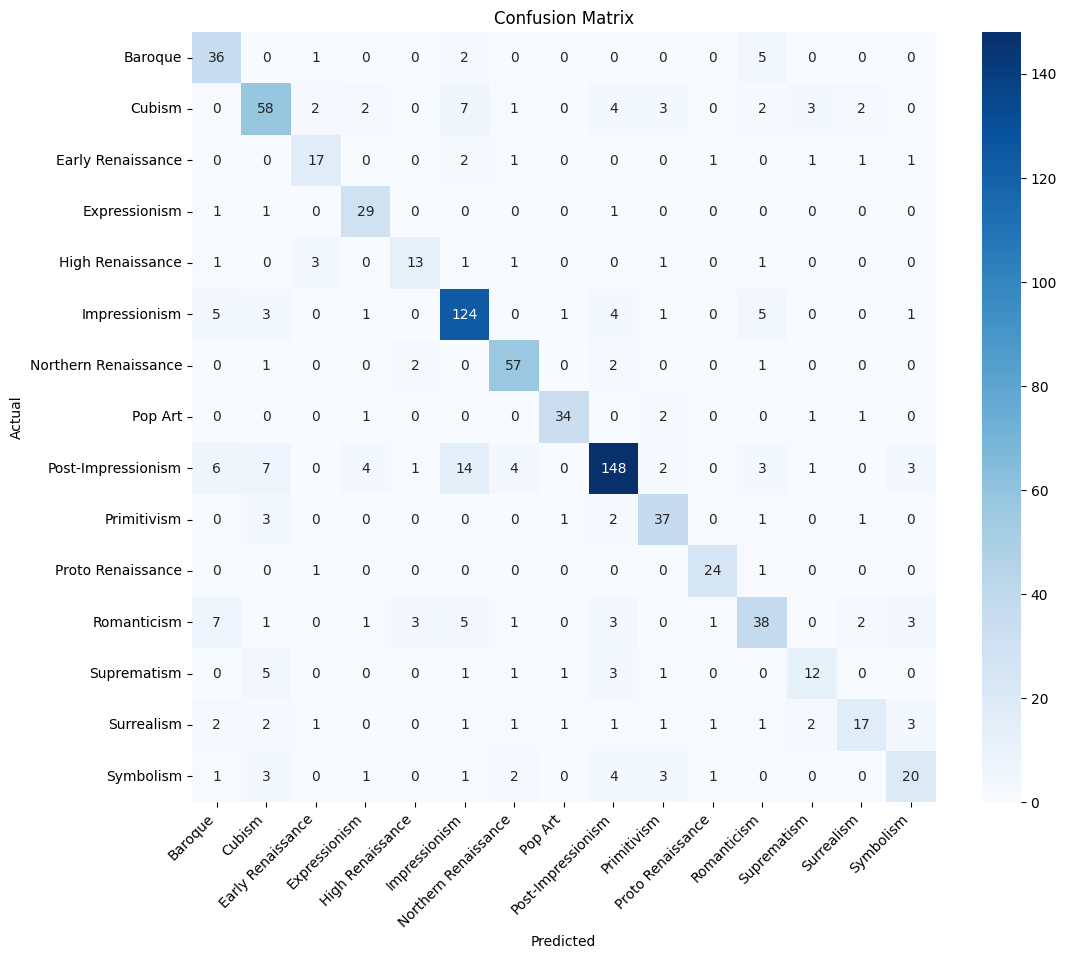

Overall ROC-AUC (Micro): 0.9670


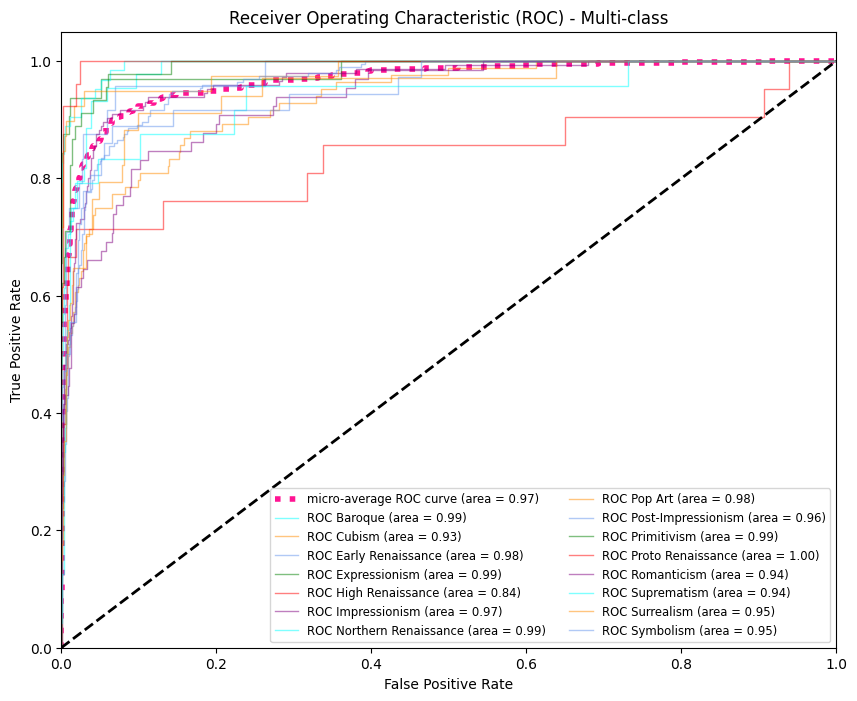

Overall PR-AUC (Micro): 0.8193


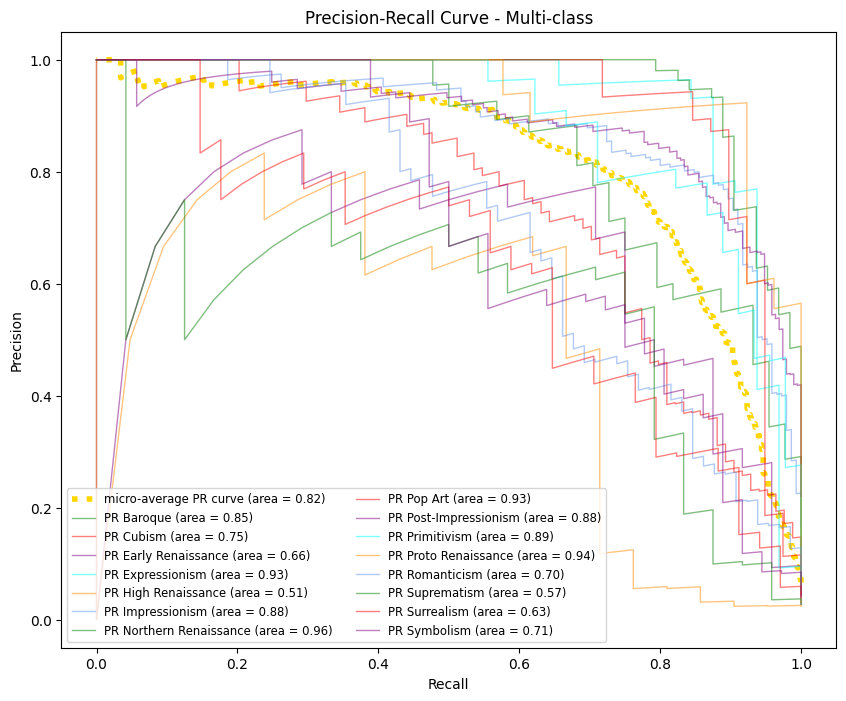

In [57]:
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', LogisticRegression(
        solver='saga',                    
        max_iter=1000,
        class_weight = 'balanced'
    ))
])
param_grid_softmax = {
        'clf__C': [0.1, 1, 10], 
}
grid_softmax = GridSearchCV(pipeline, param_grid_softmax, cv=3, n_jobs=-1, verbose=1)

print("\nStarting Training...")
grid_softmax.fit(X_train, y_train)

# check how much PCA compressed the data
n_components = grid_softmax.best_estimator_.named_steps['pca'].n_components_
print(f"PCA reduced features from {X.shape[1]} to {n_components}")

print("\n--- Evaluation Results ---")
evaluate_model(grid_softmax.best_estimator_, X_test, y_test, classes)

# Training (SVM)

Starting Grid Search for SVM...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best SVM Parameters: {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV Accuracy: 74.85%
--- Scalar Metrics ---
                 Metric     Value
0              Accuracy  0.772571
1  Precision (weighted)  0.776029
2     Recall (weighted)  0.772571
3   F1 Score (weighted)  0.765089
4     Specificity (avg)  0.982723




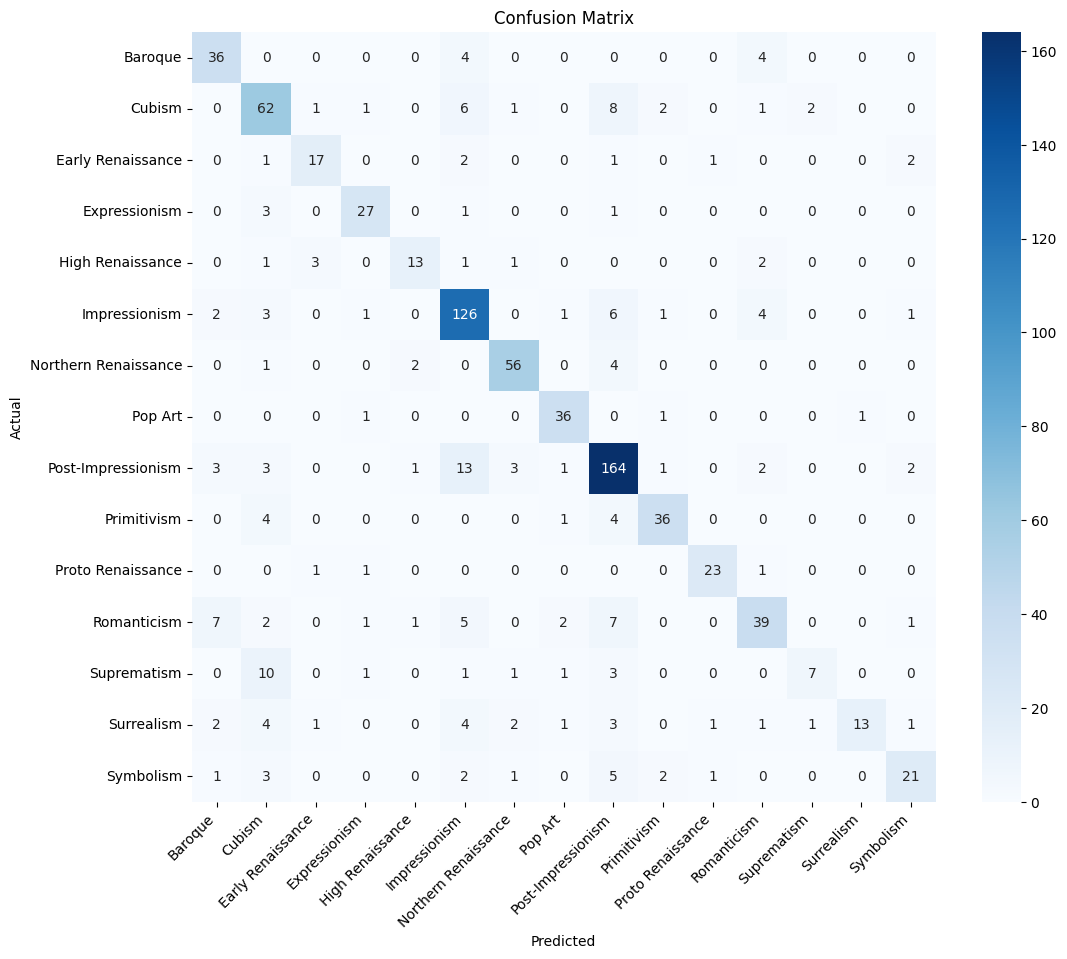

Overall ROC-AUC (Micro): 0.9798


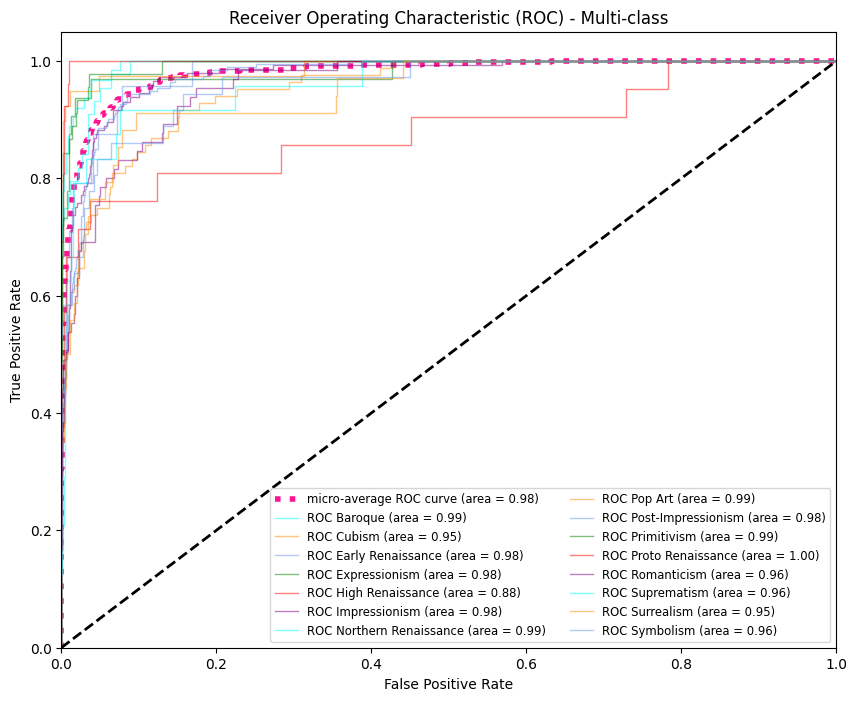

Overall PR-AUC (Micro): 0.8603


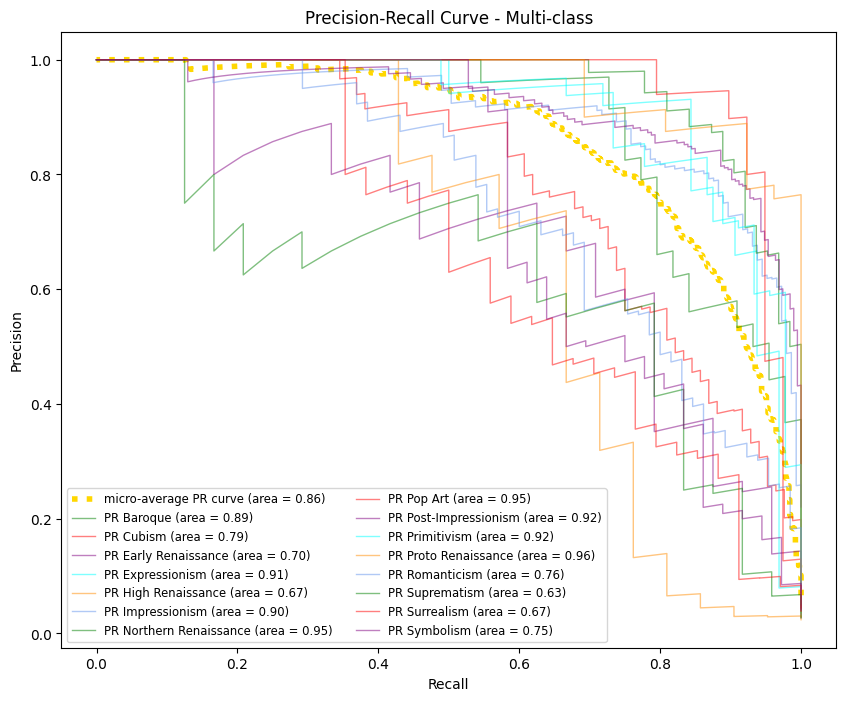

In [51]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99)), 
    ('svm', SVC(
        class_weight='balanced',
        random_state=42,
        probability=True,
        C = 10,
        cache_size=1000          # Uses 1GB RAM for cache to speed up training
    ))
])

param_grid_svm = {
    'svm__C': [1, 10, 100],             
    'svm__gamma': ['scale', 0.001, 0.01], 
}

print("Starting Grid Search for SVM...")
grid_svm = GridSearchCV(
    svm_pipeline, 
    param_grid_svm, 
    n_jobs=-1,
    cv=3,
    scoring='accuracy',
    verbose=1
)

grid_svm.fit(X_train, y_train)

print(f"\nBest SVM Parameters: {grid_svm.best_params_}")
print(f"Best CV Accuracy: {grid_svm.best_score_:.2%}")

# Evaluate
best_svm = grid_svm.best_estimator_
evaluate_model(best_svm, X_test, y_test, classes)

# Training (Random Forest)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Scalar Metrics ---
                 Metric     Value
0              Accuracy  0.614857
1  Precision (weighted)  0.663402
2     Recall (weighted)  0.614857
3   F1 Score (weighted)  0.580092
4     Specificity (avg)  0.969884




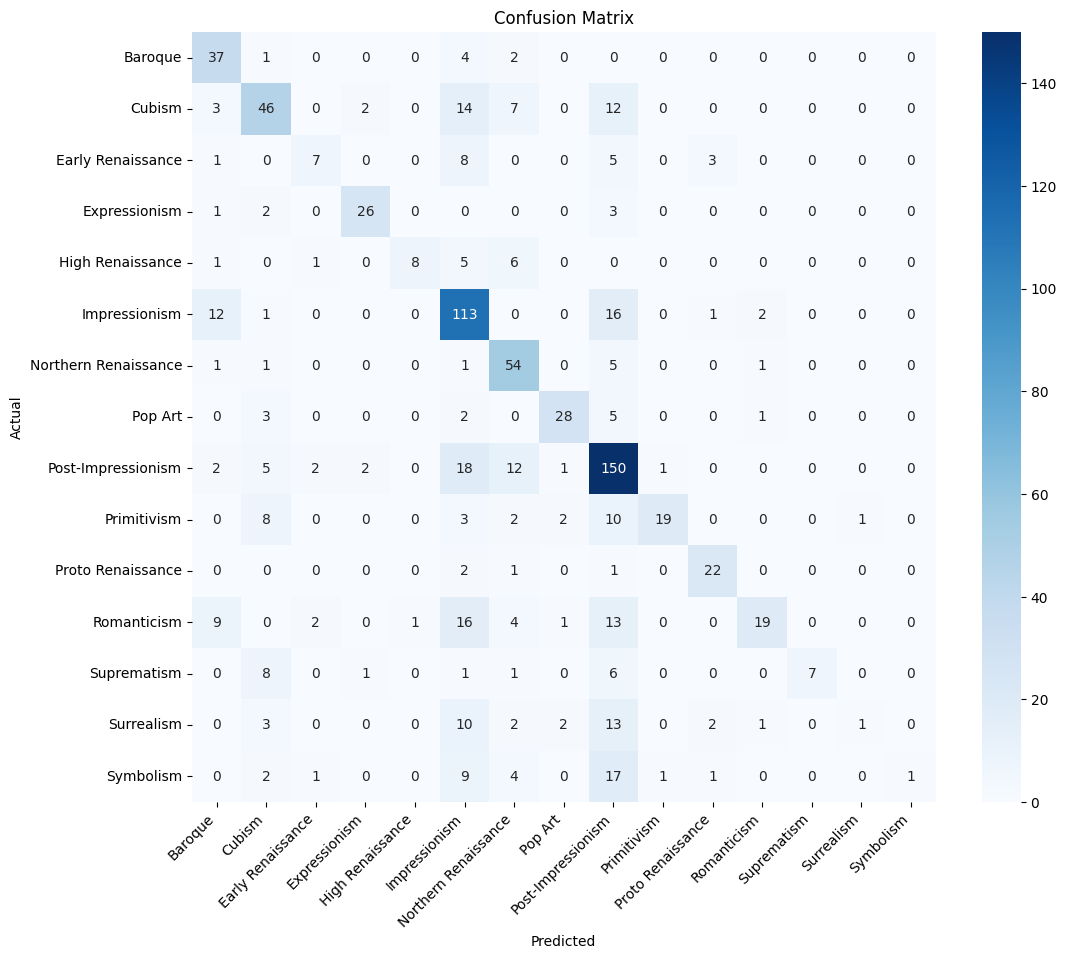

Overall ROC-AUC (Micro): 0.9164


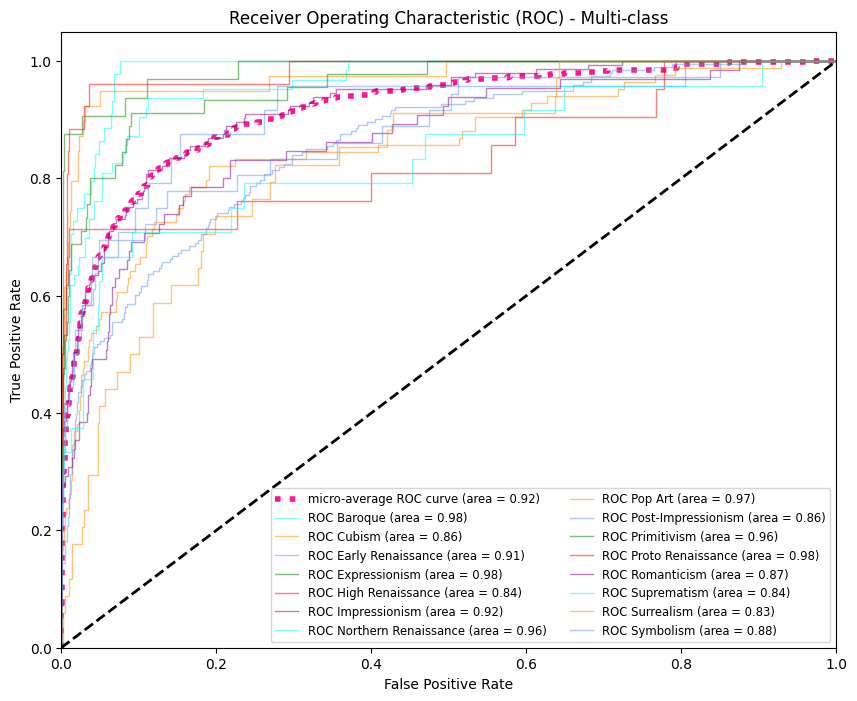

Overall PR-AUC (Micro): 0.6237


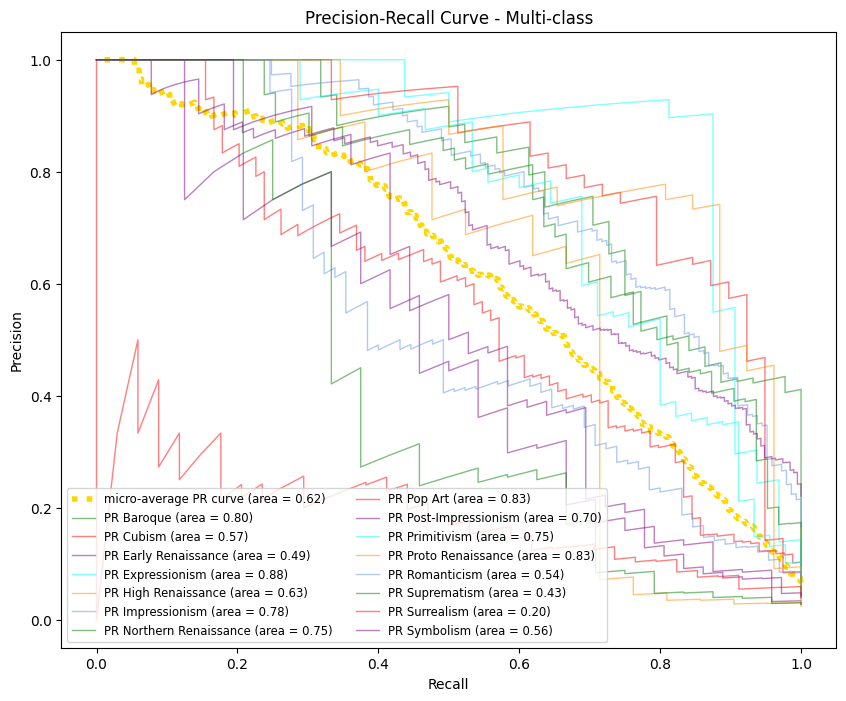

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])
param_dist_rf = {
        'rf__n_estimators': [200, 500],
        'rf__max_depth': [10, 20, 30, None],
        'rf__min_samples_leaf': [1, 2, 4]
}

random_rf = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist_rf, 
                                   n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_rf.fit(X_train, y_train)

evaluate_model(random_rf.best_estimator_, X_test, y_test, classes)